# Identifying emerging market segments with k-means

### Andrew Hetherington, 14th June 2020¶

This notebook accompanies a [blog post on Medium](https://medium.com/@andrew.m.hetherington/identifying-emerging-market-segments-with-k-means-bf221147528f).

EY’s [Future Consumer Index](https://www.ey.com/en_gl/consumer-products-retail/how-covid-19-could-change-consumer-behavior) is a short, 8-minute read that pulls together the results of a survey of 4,859 consumers across the US, Canada, UK, France and Germany during the week of 6 April 2020.  Using some rather snazzy data visualisation techniques, EY proposes the emergence of five distinct types of consumer in the aftermath of the Covid-19 pandemic, each with differing behaviours and sentiment in regard to their purchasing decisions.  Some of these types are pessimistic—cutting deep their expenditures—while some are greatly optimistic, jumping at the opportunity to spend more as restrictions are gradually lifted.

It’s not clear exactly how EY defines these five types (“get to normal”, “cautiously extravagant”, “stay frugal”, “keep cutting”, and “back with a bang”) beyond general qualitative descriptions.  However, it did get me thinking.  Two of the key variables EY have considered are optimism and income.  Clearly, optimism relates to how willing a consumer is to spend and income relates to how able they are to do so—and both will feed into an individual’s purchasing decisions.  Suppose that we had access to quantitative data on consumers’ relative levels of optimism and income.  How could we divide consumers up into groups, based on these data, in a rigorous and reproducible way?  

### The k-means algorithm

K-means clustering is a method that classifies a number of points into k groups.  Briefly, the algorithm searches a space for k “centroids” and allocates each data point to one of these centroids.  The algorithm then iterates over and over, aiming to minimise the variance within each cluster.  In this way, we eventually find k groups which are (hopefully) distinct and reflect the true natures of the groups within the data. 
To illustrate, let’s create a dataset in which there are five groups of 100 consumers each.  Suppose that each group has a typical level of income and optimism, with some natural variation around these values.  We could represent the situation graphically like so:

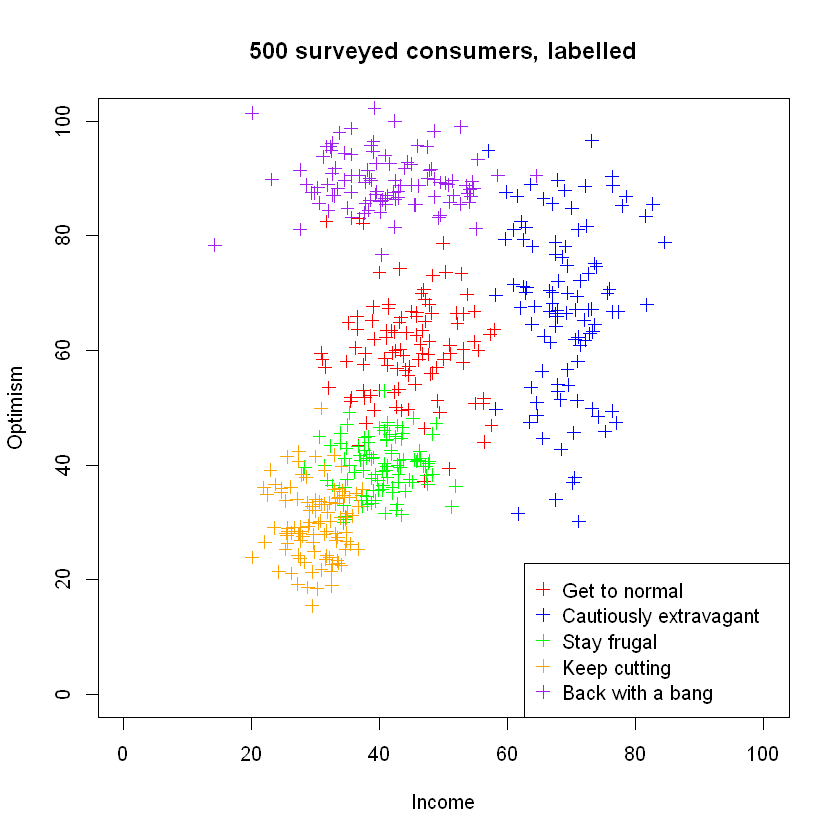

In [1]:
# Set seed for reproducibility
set.seed(13)


# Generate data

# Get to normal
mu_normal_income <- 45
sigma_normal_income <- 7

mu_normal_optimism <- 60
sigma_normal_optimism <- 8

normal_incomes <- rnorm(100, mu_normal_income, sigma_normal_income)
normal_optimisms <- rnorm(100, mu_normal_optimism, sigma_normal_optimism)

data <- cbind(normal_incomes, normal_optimisms, rep("normal", 100))
colnames(data) <- c("income", "optimism", "consumer_type")


# Cautiously extravagant
mu_extravagant_income <- 70
sigma_extravagant_income <- 5

mu_extravagant_optimism <- 65
sigma_extravagant_optimism <- 15

extravagant_incomes <- rnorm(100, mu_extravagant_income, sigma_extravagant_income)
extravagant_optimisms <- rnorm(100, mu_extravagant_optimism, sigma_extravagant_optimism)

data <- rbind(data, cbind(extravagant_incomes, extravagant_optimisms, rep("extravagant", 100)))


# Stay frugal
mu_frugal_income <- 40
sigma_frugal_income <- 5

mu_frugal_optimism <- 40
sigma_frugal_optimism <- 5

frugal_incomes <- rnorm(100, mu_frugal_income, sigma_frugal_income)
frugal_optimisms <- rnorm(100, mu_frugal_optimism, sigma_frugal_optimism)

data <- rbind(data, cbind(frugal_incomes, frugal_optimisms, rep("frugal", 100)))


# Keep cutting
mu_cutting_income <- 30
sigma_cutting_income <- 4

mu_cutting_optimism <- 30
sigma_cutting_optimism <- 6

cutting_incomes <- rnorm(100, mu_cutting_income, sigma_cutting_income)
cutting_optimisms <- rnorm(100, mu_cutting_optimism, sigma_cutting_optimism)

cutting_data <- cbind(cutting_incomes, cutting_optimisms, rep("cutting", 100))

data <- rbind(data, cbind(cutting_incomes, cutting_optimisms, rep("cutting", 100)))


# Back with a bang
mu_bang_income <- 40
sigma_bang_income <- 10

mu_bang_optimism <- 90
sigma_bang_optimism <- 5

bang_incomes <- rnorm(100, mu_bang_income, sigma_bang_income)
bang_optimisms <- rnorm(100, mu_bang_optimism, sigma_bang_optimism)

bang_data <- cbind(bang_incomes, bang_optimisms, rep("bang", 100))

data <- rbind(data, cbind(bang_incomes, bang_optimisms, rep("bang", 100)))


# Prepare plot

incomes <- cbind(normal_incomes, extravagant_incomes, frugal_incomes, cutting_incomes, bang_incomes)
optimisms <- cbind(normal_optimisms, extravagant_optimisms, frugal_optimisms, cutting_optimisms, bang_optimisms)

colours <- c("red", "blue", "green", "orange", "purple")

# Set up an empty plotting area
plot(NULL, xlim=c(0,100), ylim=c(0,100), xlab="Income", ylab="Optimism",
     main="500 surveyed consumers, labelled")

# Plot data points
for (i in 1:5){
  points(incomes[,i], optimisms[,i], col=colours[i], pch=3)
}

# Add legend
legend("bottomright", c("Get to normal", "Cautiously extravagant", "Stay frugal", "Keep cutting", "Back with a bang"), 
       col=c("red", "blue", "green", "orange", "purple"), pch=rep(3,5))

The case of having two variables is particularly straightforward to think about as each point lives somewhere in this 2D income–optimism "space". However, the k-means algorithm can be applied in an arbitrary number of dimensions - that is, we could just as easily expand our model to include a third variable (perhaps one relating to the country in which they live, as different governments have effected different measures to deal with the virus), a fourth one, and beyond.
Of course, in the real world we wouldn't know the characteristics of the groups beforehand - and we wouldn't even know how many groups there were (if any)! So momentarily forget what I've told you do far and see if you can divide the following data points up into groups:

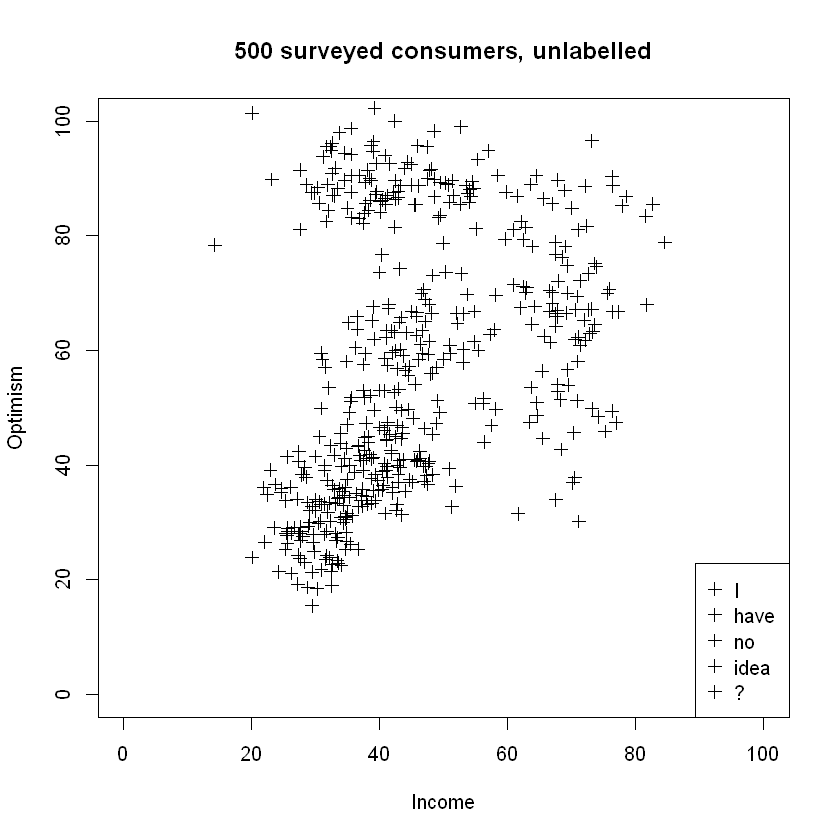

In [2]:
# Set up an empty plotting area
plot(NULL, xlim=c(0,100), ylim=c(0,100), xlab="Income", ylab="Optimism",
    main="500 surveyed consumers, unlabelled")

# Plot data points
points(data[,1], data[,2], pch=3)

# Add legend
legend("bottomright", c("I", "have", "no", "idea", "?"), 
       col=rep("black",5), pch=rep(3,5))

Not quite so simple, is it? It's definitely possible to identify some clusters, but how many are there and where does one cluster end and another begin? Ask ten different people and you will get ten different answers. But with k-means, we can take a mathematical, data-driven approach that will give the same answer each time. Let's apply the algorithm and see what we get:

In [3]:
# Fit model
model <- kmeans(data[,1:2], centers=5)

# Extract clusters
clusters <- model$cluster
print(clusters)

cat("\n")

# Extract centroids
centroids <- model$centers
print(centroids)

  [1] 3 3 5 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 2 3 3 5 3 3 3 5 3 3 3 3 3 3 3 3
 [38] 3 3 5 3 5 5 5 3 3 5 3 5 5 5 3 5 3 3 3 3 5 3 4 3 3 3 3 3 5 3 3 3 5 4 3 3 4
 [75] 3 4 3 3 3 3 3 3 5 3 3 5 3 3 5 3 3 3 3 5 3 3 3 3 3 3 2 2 2 2 2 2 2 2 5 5 2
[112] 2 2 2 5 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 5 2 5 2 2 2 2 5
[149] 4 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[186] 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 5 1 5 5 1 5 5 5 1 5 1 5 5 5 5 5 5 5 5 5 1 1
[223] 5 5 1 1 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 1 5 5 5 5 5 1 5 1 1 5 5 5 5 5 3 5
[260] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 5 5 1 5
[297] 5 5 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[334] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1
[371] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4
[408] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[445] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

We can see that, as asked, k-means has found us five centroids and has classified each data point into one of five clusters, based on its distance from the centroid. Let's plot our results to get a better understanding:

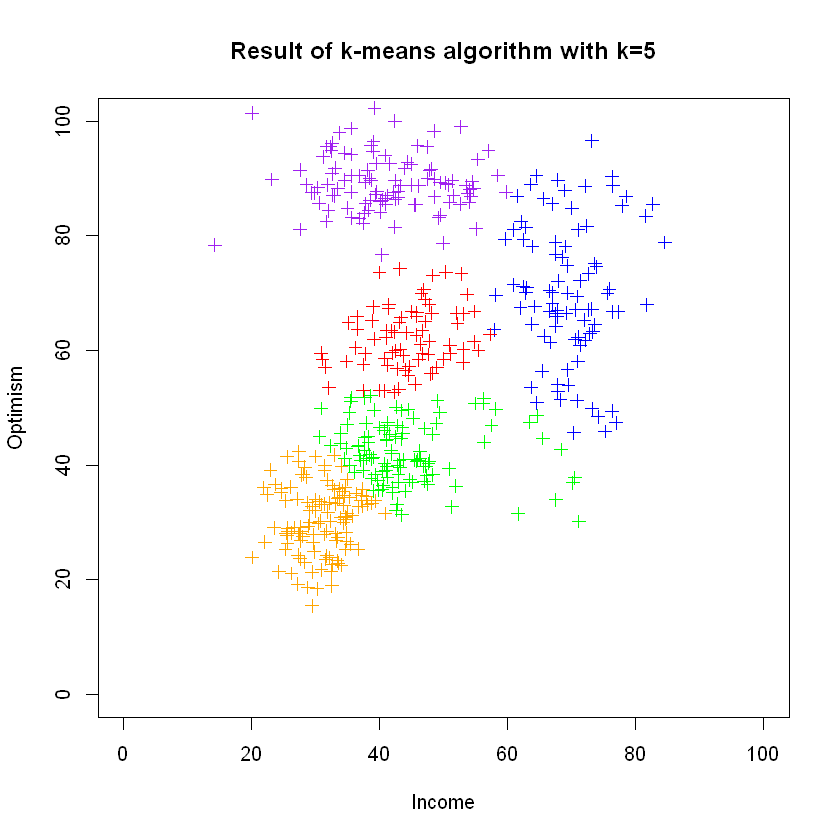

In [4]:
# Add cluster info to data
data <- cbind(data, clusters)

# Map cluster numbers to colours for plotting
colours <- c("orange", "blue", "red", "purple", "green")

map_colours <- function(num){
  colours[num]
}

clusters_colours <- lapply(clusters, map_colours)

# Set up an empty plotting area
plot(NULL, xlim=c(0,100), ylim=c(0,100), xlab="Income", ylab="Optimism", main="Result of k-means algorithm with k=5")

# Plot data points
for (i in 1:500){
  points(data[i,1], data[i,2], col=colours[as.integer(data[i,4])], pch=3)
}

We can see that k-means has done a pretty good job overall—the algorithm has been able to pick out the general characteristics of the five groups in terms of optimism and income.  In this example, we have the ground truth to hand so we can see that k-means has grouped some of the more pessimistic “cautiously extravagant” consumers with the bulk of the “stay frugal” cluster.  Although we know that k-means has got this aspect of the problem “wrong”, there are undoubtedly areas of overlap between the five types of consumer.  This may even prove to be a useful insight—the algorithm has pointed out a similarity between these customers that we may not have picked up on otherwise.  

### Conclusion
The k-means algorithm does have its limitations but it can reveal patterns and trends in data that may not be immediately visible to the human eye.  This is why clustering algorithms are so often used in exploratory data analysis when we’re seeking to understand a new an unfamiliar dataset.  We continue to produce data at an astounding rate whenever we make purchases—and you can bet that there will be no end of analysts using techniques just like this in hopes of making sense of it all as economies gradually recover in a post-pandemic world.